In [ ]:
#@title Check if MuJoCo installation was successful

import distutils.util
import os
import subprocess
if subprocess.run('nvidia-smi').returncode:
  raise RuntimeError(
      'Cannot communicate with GPU. '
      'Make sure you are using a GPU Colab runtime. '
      'Go to the Runtime menu and select Choose runtime type.')

# Add an ICD config so that glvnd can pick up the Nvidia EGL driver.
# This is usually installed as part of an Nvidia driver package, but the Colab
# kernel doesn't install its driver via APT, and as a result the ICD is missing.
# (https://github.com/NVIDIA/libglvnd/blob/master/src/EGL/icd_enumeration.md)
NVIDIA_ICD_CONFIG_PATH = '/usr/share/glvnd/egl_vendor.d/10_nvidia.json'
if not os.path.exists(NVIDIA_ICD_CONFIG_PATH):
  with open(NVIDIA_ICD_CONFIG_PATH, 'w') as f:
    f.write("""{
    "file_format_version" : "1.0.0",
    "ICD" : {
        "library_path" : "libEGL_nvidia.so.0"
    }
}
""")

# Configure MuJoCo to use the EGL rendering backend (requires GPU)
print('Setting environment variable to use GPU rendering:')
%env MUJOCO_GL=egl

try:
  print('Checking that the installation succeeded:')
  import mujoco
  mujoco.MjModel.from_xml_string('<mujoco/>')
except Exception as e:
  raise e from RuntimeError(
      'Something went wrong during installation. Check the shell output above '
      'for more information.\n'
      'If using a hosted Colab runtime, make sure you enable GPU acceleration '
      'by going to the Runtime menu and selecting "Choose runtime type".')

print('Installation successful.')
print('Nvidia CUDA Compiler:')
!nvcc --version

In [2]:
#@title Import packages for plotting and creating graphics
import time
import itertools
import numpy as np
from typing import Callable, NamedTuple, Optional, Union, List

import mediapy as media
import matplotlib.pyplot as plt

# More legible printing from numpy.
np.set_printoptions(precision=3, suppress=True, linewidth=100)

#@title Import MuJoCo, MJX, and Brax
from datetime import datetime
import functools
from IPython.display import HTML
import jax
from jax import numpy as jp
from jax import config, debug
config.update("jax_debug_nans", True)
# config.update('jax_default_matmul_precision', jax.lax.Precision.HIGH)
import numpy as np
from typing import Any, Dict, Sequence, Tuple, Union

from brax import base
from brax import envs
from brax import math
from brax.base import Base, Motion, Transform
from brax.envs.base import Env, PipelineEnv, State
from brax.mjx.base import State as MjxState
from brax.training.agents.ppo import train as ppo
from brax.training.agents.ppo import networks as ppo_networks
from brax.io import html, mjcf, model

from etils import epath
from flax import struct
from matplotlib import pyplot as plt
import mediapy as media
from ml_collections import config_dict
import mujoco
from mujoco import mjx

import os
# os.environ["XLA_PYTHON_CLIENT_MEM_FRACTION"]=".50"

## Visualize Panda Robot

""

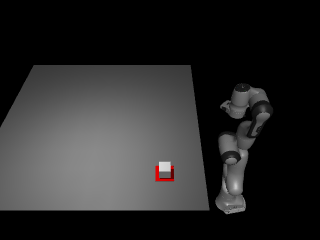

In [3]:
model = mujoco.MjModel.from_xml_path("panda_nohand.xml")
data = mujoco.MjData(model)

renderer = mujoco.Renderer(model)
mujoco.mj_step(model, data)

renderer.update_scene(data)
media.show_image(renderer.render())

""

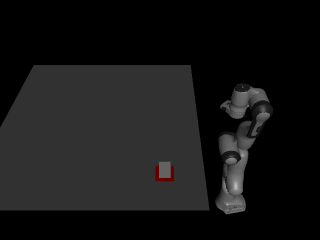

In [4]:
# Change integrator to RK4, because conversion to mjx is not possible for default implicit 
model.opt.integrator = mujoco.mjtIntegrator.mjINT_RK4
# Create MJX instances from MuJoCo
mjx_model = mjx.put_model(model)
mjx_data = mjx.put_data(model, data)

render_mjx_data = mjx.get_data(model, mjx_data)
renderer.update_scene(render_mjx_data) 
media.show_image(renderer.render())

## Create MJX Environment for RL

In [5]:
class FrankaEnv(PipelineEnv):

    def __init__(
        self,
        **kwargs,
        ):
        model_path ="panda_nohand.xml"
        # xml_models/franka_emika_panda/panda_nohand_test.xml 
        # xml_models/panda/robot.xml        
        mj_model = mujoco.MjModel.from_xml_path(model_path)
        mj_model.opt.solver = mujoco.mjtSolver.mjSOL_CG
        mj_model.opt.iterations = 6
        mj_model.opt.ls_iterations = 6
        mj_model.opt.integrator = mujoco.mjtIntegrator.mjINT_RK4
        sys = mjcf.load_model(mj_model)
        
        physics_steps_per_control_step = 5
        kwargs['n_frames'] = kwargs.get(
                'n_frames', physics_steps_per_control_step)
        kwargs['backend'] = 'mjx'

        super().__init__(sys, **kwargs)
        
    
    def reset(self, rng: jp.ndarray) -> State:
        """Resets the environment to an initial state."""
        rng, rng1, rng2 = jax.random.split(rng, 3)
        
        qpos = self.sys.qpos0

        goal_pos = jp.asarray([0.0, 0.0])
        cylinder_pos = jp.concatenate([
                    jax.random.uniform(rng, (1,), minval=-0.2, maxval=-1e-6),
                    jax.random.uniform(rng1, (1,), minval=-0.15, maxval=0.15),
        ])
        norm = jp.linalg.norm(cylinder_pos - goal_pos)
        scale = jp.where(norm < 0.17, 0.17 / norm, 1.0)
        cylinder_pos *= scale
        
        qpos = qpos.at[-4:].set(jp.concatenate([cylinder_pos, goal_pos]))
        
        qvel = jax.random.uniform(rng2, (self.sys.nv,), minval=-0.005, maxval=0.005)
        qvel = qvel.at[-4:].set(0.0)
        
        data = self.pipeline_init(qpos, qvel)
        obs = self._get_obs(data)
        reward, done, zero = jp.zeros(3)
        metrics = {
            "reward_dist": zero,
            "reward_ctrl": zero,
            "reward_near": zero,
        }
        # print('reset')
        return State(data, obs, reward, done, metrics)
    

    
    def step(self, state: State, action: jp.ndarray) -> State:
        data0 = state.pipeline_state

        vec_1 = data0.xpos[-2,:] - data0.xpos[-3,:]
        vec_2 = data0.xpos[-2,:] - data0.xpos[-1,:]
        reward_near = -jp.linalg.norm(vec_1)
        reward_dist = -jp.linalg.norm(vec_2)
        reward_ctrl = -jp.square(action).sum()
        reward = reward_dist + 0.1 * reward_ctrl + 0.5 * reward_near
        
        data = self.pipeline_step(state.pipeline_state, action)

        obs = self._get_obs(data)
        
        state.metrics.update(
            reward_dist = reward_dist,
            reward_ctrl = reward_ctrl,
            reward_near = reward_near,         
        )
        # print('step ends')
        # debug.print("vec_1:{x}",x=vec_1)
        # debug.print("reward_near:{x}",x=reward_near)
        # debug.print("q:{x}",x=data.qpos[:7])
        # debug.print("goal_pos:{x}",x=data0.xpos[-1,:])
        return state.replace(pipeline_state=data, obs=obs, reward=reward)

    def _get_obs(self, data: mjx.Data) -> jp.ndarray:
        return jp.concatenate([
            data.qpos[:7],
            data.qvel[:7],
            data.xpos[-3,:],                       # attachment #
            data.xpos[-2,:],                       # object #
            data.xpos[-1,:],                       # goal #
        ])
        
envs.register_environment('frankaenv', FrankaEnv)

In [6]:
# instantiate the environment
env_name = 'frankaenv'
env = envs.get_environment(env_name)

# define the jit reset/step functions
jit_reset = jax.jit(env.reset)
jit_step = jax.jit(env.step)

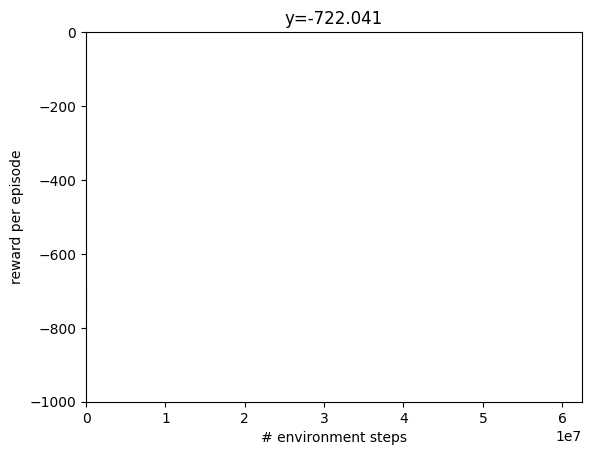

In [16]:
train_fn = functools.partial(
    ppo.train, num_timesteps=50_000_000, num_evals=20, reward_scaling=5, 
    episode_length=1000, normalize_observations=True, action_repeat=1, 
    unroll_length=30, num_minibatches=16, num_updates_per_batch=8, 
    discounting=0.95, learning_rate=3e-4, entropy_cost=1e-2, num_envs=2048, 
    batch_size=512, seed=3)


x_data = []
y_data = []
ydataerr = []
times = [datetime.now()]

max_y, min_y = 0, -1000
def progress(num_steps, metrics):
  times.append(datetime.now())
  x_data.append(num_steps)
  y_data.append(metrics['eval/episode_reward'])
  ydataerr.append(metrics['eval/episode_reward_std'])

  plt.xlim([0, train_fn.keywords['num_timesteps'] * 1.25])
  plt.ylim([min_y, max_y])

  plt.xlabel('# environment steps')
  plt.ylabel('reward per episode')
  plt.title(f'y={y_data[-1]:.3f}')

  plt.errorbar(
      x_data, y_data, yerr=ydataerr)
  plt.show()

make_inference_fn, params, _= train_fn(environment=env, progress_fn=progress)

print(f'time to jit: {times[1] - times[0]}')
print(f'time to train: {times[-1] - times[1]}')

In [ ]:
# # initialize the state
# state = jit_reset(jax.random.PRNGKey(0))
# rollout = [state.pipeline_state]

# # grab a trajectory
# for i in range(10):
#   ctrl = -0.1 * jp.ones(env.sys.nu)
#   state = jit_step(state, ctrl)
#   rollout.append(state.pipeline_state)

# media.show_video(env.render(rollout), fps=1.0 / env.dt)

In [ ]:
model.save_params('/tmp/params', params)
params = model.load_params('/tmp/params')
inference_fn = make_inference_fn(params)